In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import dask.dataframe as dd
import os

In [50]:
data = {
    'player_id': range(1, 100001),
    'age': np.random.randint(18, 78, 100000),
    'bets_placed': np.random.randint(1, 100, 100000),
    'total_amount_bet': np.random.uniform(100, 10000, 100000)
}

df = pd.DataFrame(data)

def generate_wins_losses(bets_placed):
    wins = np.random.binomial(bets_placed, 0.49)
    losses = bets_placed - wins
    return wins, losses

df[['wins', 'losses']] = df['bets_placed'].apply(lambda x: pd.Series(generate_wins_losses(x)))

print(df.head())
print(df.shape)

   player_id  age  bets_placed  total_amount_bet  wins  losses
0          1   33           34       6025.974086    17      17
1          2   66           47       6558.010244    24      23
2          3   63           84        828.151117    40      44
3          4   73           88       6332.060716    42      46
4          5   35           45       5930.435164    22      23
(100000, 6)


age
56    1795
75    1751
44    1742
20    1734
37    1731
Name: count, dtype: int64
bets_placed
33    1086
4     1082
3     1081
96    1071
58    1067
Name: count, dtype: int64


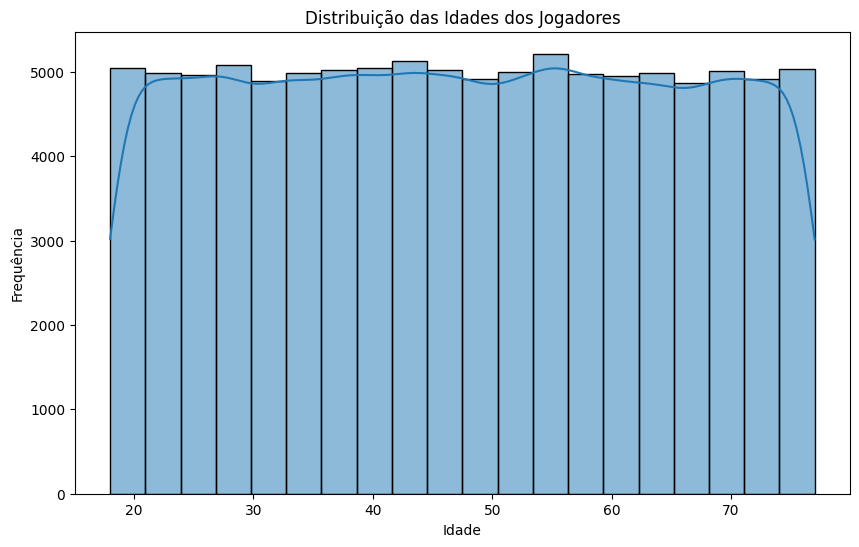

In [51]:
print(df.age.value_counts()[:5])
print(df.bets_placed.value_counts()[:5])

plt.figure(figsize=(10, 6))
# plt.hist(df['age'],bins=15)
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Distribuição das Idades dos Jogadores')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()


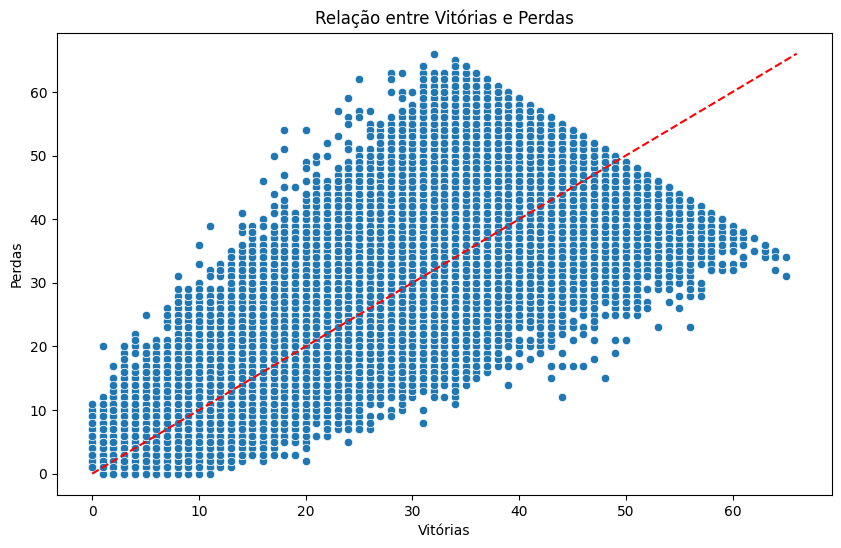

In [52]:
maior_valor = max(df['wins'].max(), df['losses'].max())

plt.figure(figsize=(10, 6))
sns.scatterplot(x='wins', y='losses', data=df)
plt.plot([0, maior_valor], [0, maior_valor], color='red', linestyle='--')  # linha diagonal de (0,0) a (100,100)

plt.title('Relação entre Vitórias e Perdas')
plt.xlabel('Vitórias')
plt.ylabel('Perdas')
plt.show()

In [53]:
df['net_profit'] = df['losses'] - df['wins']
df['bet_per_bet'] = df['total_amount_bet'] / df['bets_placed']
df['net_profit_per_bet'] = df['bet_per_bet'] * df['net_profit']

df.head()

,player_id,age,bets_placed,total_amount_bet,wins,losses,net_profit,bet_per_bet,net_profit_per_bet
0,1,33,34,6025.974086,17,17,0,177.234532,0.000000
1,2,66,47,6558.010244,24,23,-1,139.532133,-139.532133
2,3,63,84,828.151117,40,44,4,9.858942,39.435767
3,4,73,88,6332.060716,42,46,4,71.955235,287.820942
4,5,35,45,5930.435164,22,23,1,131.787448,131.787448


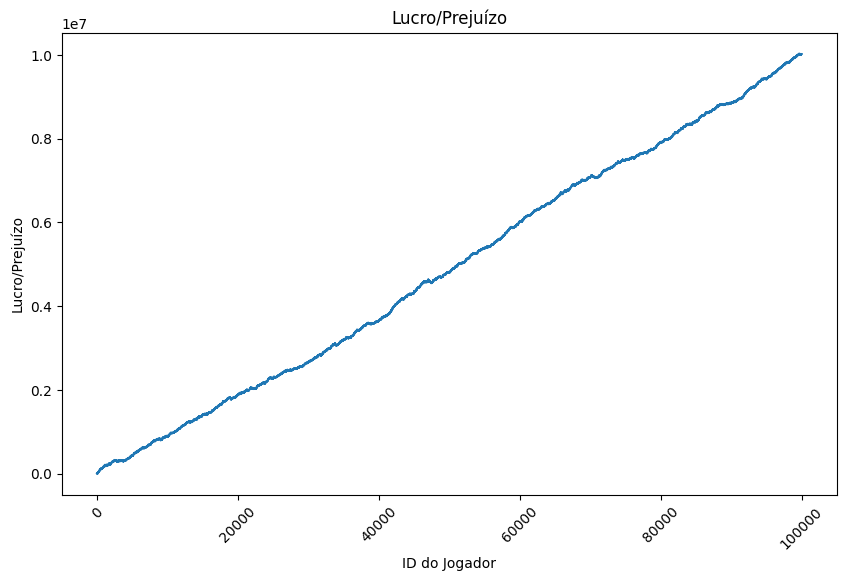

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(df['player_id'], df['net_profit_per_bet'].cumsum(),) 
plt.xlabel('ID do Jogador')
plt.ylabel('Lucro/Prejuízo')
plt.title('Lucro/Prejuízo')
plt.xticks(rotation=45)  
plt.show()

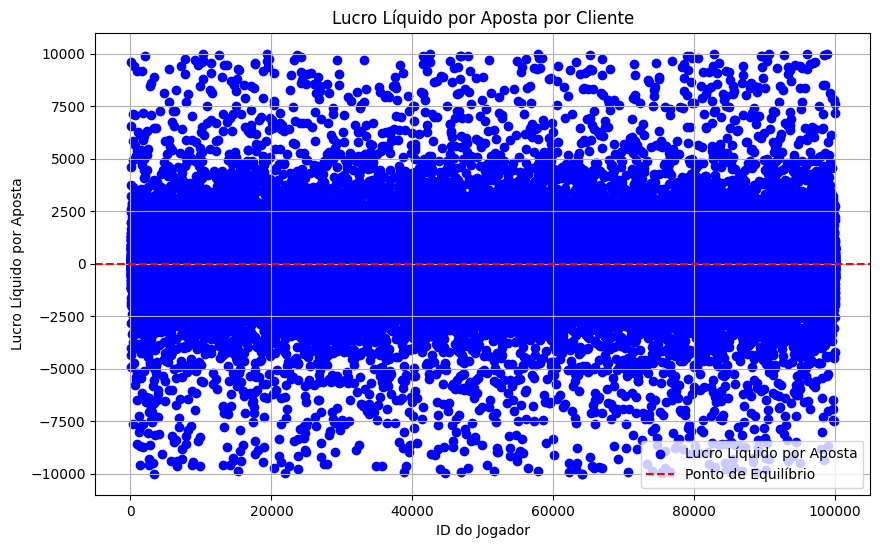

Lucro líquido total do cassino: 10019084.467273088


In [55]:

plt.figure(figsize=(10, 6))
plt.scatter(df['player_id'], df['net_profit_per_bet'], color='blue', label='Lucro Líquido por Aposta')
plt.axhline(y=0, color='red', linestyle='--', label='Ponto de Equilíbrio')
plt.xlabel('ID do Jogador')
plt.ylabel('Lucro Líquido por Aposta')
plt.title('Lucro Líquido por Aposta por Cliente')
plt.legend()
plt.grid(True)
plt.show()

total_casino_profit = df['net_profit_per_bet'].sum()


print("Lucro líquido total do cassino:", total_casino_profit)

In [56]:
df.head()

,player_id,age,bets_placed,total_amount_bet,wins,losses,net_profit,bet_per_bet,net_profit_per_bet
0,1,33,34,6025.974086,17,17,0,177.234532,0.000000
1,2,66,47,6558.010244,24,23,-1,139.532133,-139.532133
2,3,63,84,828.151117,40,44,4,9.858942,39.435767
3,4,73,88,6332.060716,42,46,4,71.955235,287.820942
4,5,35,45,5930.435164,22,23,1,131.787448,131.787448


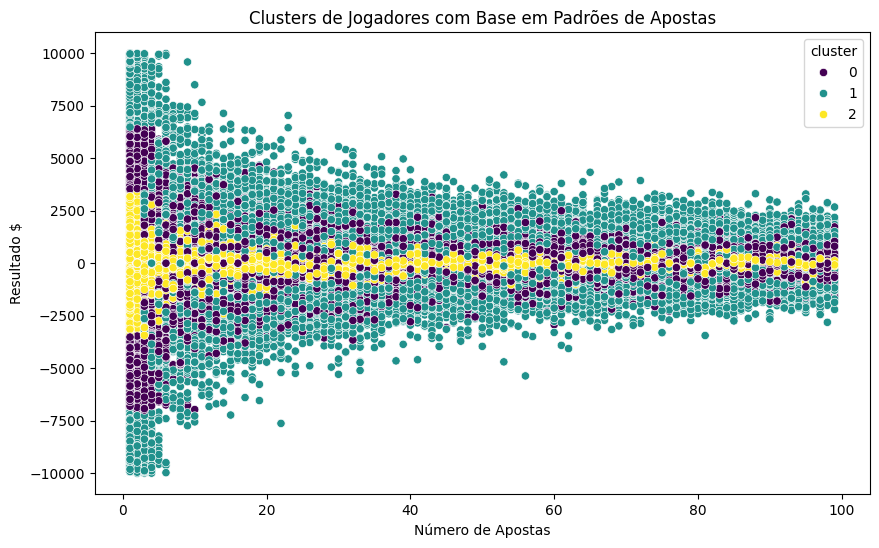

In [57]:
features = df[['bets_placed', 'total_amount_bet', 'net_profit', 'net_profit_per_bet']]
kmeans = KMeans(n_clusters=3)
df['cluster'] = kmeans.fit_predict(features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='bets_placed', y='net_profit_per_bet', hue='cluster', data=df, palette='viridis')
plt.title('Clusters de Jogadores com Base em Padrões de Apostas')
plt.xlabel('Número de Apostas')
plt.ylabel('Resultado $')
plt.show()

In [58]:
data_large = {
    'player_id': range(1, 100001),
    'age': np.random.randint(18, 60, 100000),
    'bets_placed': np.random.randint(1, 100, 100000),
    'total_amount_bet': np.random.uniform(100, 10000, 100000),
    'wins': np.random.randint(0, 50, 100000),
    'losses': np.random.randint(0, 50, 100000)
}


In [59]:
df_large = pd.DataFrame(data_large)
df_large_dd = dd.from_pandas(df_large, npartitions=10)


summary = df_large_dd.describe().compute()
print(summary)

high_betters = df_large_dd[df_large_dd['total_amount_bet'] > 5000].compute()
print(high_betters.head())

grouped = df_large_dd.groupby('age').mean().compute()
print(grouped.head())

           player_id            age    bets_placed  total_amount_bet  \
count  100000.000000  100000.000000  100000.000000     100000.000000   
mean    50000.500000      38.489920      50.149310       5051.129948   
std     28867.657797      12.107685      28.530983       2861.874613   
min         1.000000      18.000000       1.000000        100.012173   
25%     25000.500000      28.000000      26.000000       2601.621458   
50%     50000.000000      39.000000      51.000000       5120.966791   
75%     75000.500000      49.000000      75.000000       7585.016942   
max    100000.000000      59.000000      99.000000       9999.773529   

                wins         losses  
count  100000.000000  100000.000000  
mean       24.507020      24.511280  
std        14.411248      14.452497  
min         0.000000       0.000000  
25%        13.000000      12.000000  
50%        25.000000      25.000000  
75%        38.000000      37.000000  
max        49.000000      49.000000  
    playe

In [60]:
import sqlite3

if not os.path.exists('Banco'):
    os.makedirs('Banco')

conn = sqlite3.connect('Banco/example.db')
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS players (
    player_id INTEGER PRIMARY KEY,
    age INTEGER,
    bets_placed INTEGER,
    total_amount_bet REAL,
    wins INTEGER,
    losses INTEGER
)
''')

data = [(i, np.random.randint(18, 60), np.random.randint(1, 100), np.random.uniform(100, 10000), np.random.randint(0, 50), np.random.randint(0, 50)) for i in range(1, 101)]
cursor.executemany('INSERT INTO players VALUES (?, ?, ?, ?, ?, ?)', data)

# conn.commit()



In [61]:
cursor.execute('''
SELECT * FROM players 
''')
result = cursor.fetchall()
print(len(result))

100


In [62]:
cursor.execute('''
SELECT * FROM players WHERE bets_placed > 50
''')
result = cursor.fetchall()
print(len(result))

57


In [63]:
cursor.execute('''
SELECT age, AVG(total_amount_bet) as average_bet FROM players GROUP BY age
''')
result = cursor.fetchall()
print(result)

[(18, 6417.920140670313), (19, 6344.815390522423), (22, 7735.693284654315), (23, 6834.3947394294055), (24, 4405.106608007882), (25, 4768.770875280003), (26, 3718.137383895278), (27, 4567.414999620218), (28, 4198.235889450662), (29, 6753.152389163262), (30, 2811.1385632531233), (31, 5323.307331661426), (32, 6048.399597258399), (33, 8112.708995049062), (34, 9933.444438845334), (35, 6351.212426339773), (36, 5729.109146760646), (37, 1878.891072399624), (38, 8894.135314433066), (39, 7516.328486058535), (40, 6648.9283554408785), (41, 8271.904844762521), (42, 3548.3497868279455), (43, 5079.860331306138), (44, 1108.3701509976574), (45, 8776.687375332926), (46, 6869.804243548639), (47, 4072.942192077056), (48, 3039.7063580632157), (49, 3532.4649484157135), (50, 7711.289779603984), (51, 4339.007089624926), (52, 6582.122044822637), (53, 4166.308262081288), (54, 5293.756344492772), (55, 6066.911796076912), (56, 5713.778562552052), (57, 7119.161187772279), (58, 4896.49886846627), (59, 5478.85781922

In [64]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS games (
    game_id INTEGER PRIMARY KEY,
    player_id INTEGER,
    game_result TEXT,
    bet_amount REAL,
    FOREIGN KEY(player_id) REFERENCES players(player_id)
)
''')

game_data = [(i, np.random.randint(1, 101), np.random.choice(['win', 'lose']), np.random.uniform(10, 1000)) for i in range(1, 201)]
cursor.executemany('INSERT INTO games VALUES (?, ?, ?, ?)', game_data)
conn.commit()

In [65]:
cursor.execute('''
SELECT p.player_id, p.age, g.game_result, g.bet_amount
FROM players p
JOIN games g ON p.player_id = g.player_id
WHERE p.age > 30 AND g.bet_amount > 500
''')
result = cursor.fetchall()
print(result)

[(31, 46, 'lose', 789.6139758631315), (83, 59, 'lose', 625.0535564842452), (49, 42, 'win', 673.297526639478), (89, 52, 'win', 636.3462256164785), (86, 57, 'win', 558.7096424006824), (98, 38, 'win', 755.4193803634794), (67, 46, 'lose', 885.6646186097706), (40, 36, 'win', 856.981165098467), (51, 58, 'win', 979.2929191493668), (31, 46, 'win', 794.3339783634458), (90, 44, 'lose', 901.5629279715133), (69, 32, 'lose', 763.764875447557), (25, 38, 'lose', 559.7458868094457), (24, 32, 'lose', 854.0865698777441), (21, 42, 'win', 531.8240778007804), (57, 37, 'lose', 835.3497501415528), (51, 58, 'lose', 528.4251196706491), (47, 46, 'win', 653.5057151984033), (8, 31, 'lose', 794.742102089802), (55, 34, 'win', 852.5486439040765), (99, 59, 'lose', 869.9325778080223), (43, 50, 'win', 784.7765064350077), (95, 53, 'win', 523.4601464174978), (20, 40, 'lose', 944.1727565943048), (88, 33, 'lose', 989.403001531029), (24, 32, 'win', 654.8005934545243), (16, 58, 'win', 815.5115012513588), (93, 43, 'win', 938.

In [66]:
cursor.execute('''
SELECT p.player_id, p.age, g.game_result, g.bet_amount
FROM players p
JOIN games g ON p.player_id = g.player_id
WHERE p.age > 30 AND g.bet_amount > 500
''')
result = cursor.fetchall()
print(result)

[(31, 46, 'lose', 789.6139758631315), (83, 59, 'lose', 625.0535564842452), (49, 42, 'win', 673.297526639478), (89, 52, 'win', 636.3462256164785), (86, 57, 'win', 558.7096424006824), (98, 38, 'win', 755.4193803634794), (67, 46, 'lose', 885.6646186097706), (40, 36, 'win', 856.981165098467), (51, 58, 'win', 979.2929191493668), (31, 46, 'win', 794.3339783634458), (90, 44, 'lose', 901.5629279715133), (69, 32, 'lose', 763.764875447557), (25, 38, 'lose', 559.7458868094457), (24, 32, 'lose', 854.0865698777441), (21, 42, 'win', 531.8240778007804), (57, 37, 'lose', 835.3497501415528), (51, 58, 'lose', 528.4251196706491), (47, 46, 'win', 653.5057151984033), (8, 31, 'lose', 794.742102089802), (55, 34, 'win', 852.5486439040765), (99, 59, 'lose', 869.9325778080223), (43, 50, 'win', 784.7765064350077), (95, 53, 'win', 523.4601464174978), (20, 40, 'lose', 944.1727565943048), (88, 33, 'lose', 989.403001531029), (24, 32, 'win', 654.8005934545243), (16, 58, 'win', 815.5115012513588), (93, 43, 'win', 938.